In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from AbundanceMatching import *
import emcee, os
import numpy as np
from Corrfunc.theory import wp
from avocet import helpers, abundance_matching
from astropy.io import fits
import emcee, corner
from multiprocessing import Pool
%matplotlib inline

custom_colors = ["#a1dab4","#41b6c4","#2c7fb8","#253494"]

In [2]:
data_path = '/Users/sebwagner/Documents/Grad_School/Research/Risa/abundancematching/data/'
# Luminosity function
# lf_21 = np.loadtxt(data_path + 'lf/tinker/lf_jt_21.dat')
lf_20 = np.loadtxt(data_path + 'lf_jt_20.dat')
lf_18 = np.loadtxt(data_path + 'lf_jt_18.dat')
# lf_21 = lf_21[lf_21[:,1]>0,:]
lf_20 = lf_20[lf_20[:,1]>0,:]
lf_18 = lf_18[lf_18[:,1]>0,:]

# Load the wp data.
wp_path = data_path
r_cutoff = 15
wp_20, wp_20_cov, wp_20_var = helpers.get_wp_data(wp_path,20,r_cutoff)
#wp_18, wp_18_cov, wp_18_var = helpers.get_wp_data(wp_path,18,r_cutoff)
wp_21, wp_21_cov, wp_21_var = helpers.get_wp_data(wp_path,21,r_cutoff)

box_size = 400
pimax = 40.0
scatters = [0.1,0.2,0.3]
deconv_repeat = 20
mag_cut_list=[-21.0,-20.0]#,-18.0]

# Use lf_20 twice since we don't have an lf_21
lf_list = [lf_20,lf_20]#,lf_18]

# Halos from n body sim
halo_path = '/Users/sebwagner/Downloads/hlists/'
halos = np.array(fits.open(halo_path + 'hlist_1.00000.list.fits')[1].data)
r_p_data = wp_20[:,0]
wp_data_list = [wp_21[:,1],wp_20[:,1]]#,wp_18[:,1]]
wp_cov_list = [wp_21_cov*4,wp_20_cov*4]#,wp_18_cov]
wp_std_list = [np.sqrt(wp_21_var),np.sqrt(wp_20_var)]

### First plot the two point correlation functions we extracted to make sure they're reasonable

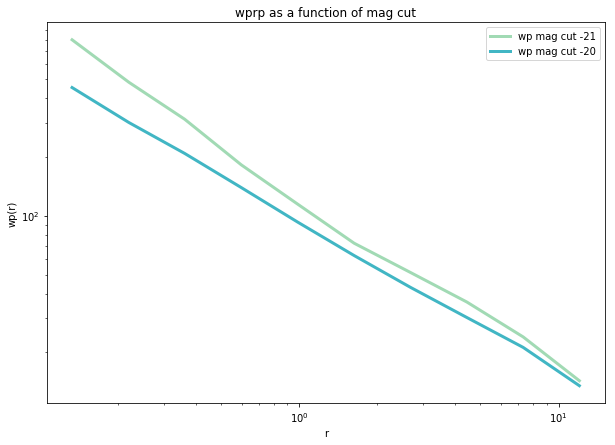

In [3]:
legend = []
plt.figure(figsize=(10,7))
for mi,mag in enumerate(mag_cut_list):
    plt.plot(r_p_data,wp_data_list[mi],c=custom_colors[mi],lw=3)
    legend.append('wp mag cut %d'%(mag))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('r')
plt.ylabel('wp(r)')
plt.legend(legend)
plt.title('wprp as a function of mag cut')
plt.show()

### Now let's run the whole abundance matching pipeline once and make sure what comes out is reasonable.

In [4]:
# We set the halo properties as global variables to speed up calculation.
abundance_matching.set_halo_cat_props(halos['vmax'], halos['px'],halos['py'], halos['pz'],box_size)
abundance_matching.set_lf(lf_list,mag_cut_list)

In [5]:
scatter = 0.2
wp_binneds = abundance_matching.generate_wp(r_p_data,[scatter],pimax=40.0,deconv_repeat=deconv_repeat,n_wp_samps=3)

/Users/sebwagner/.local/lib/python3.6/site-packages/Corrfunc/utils.py:914: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


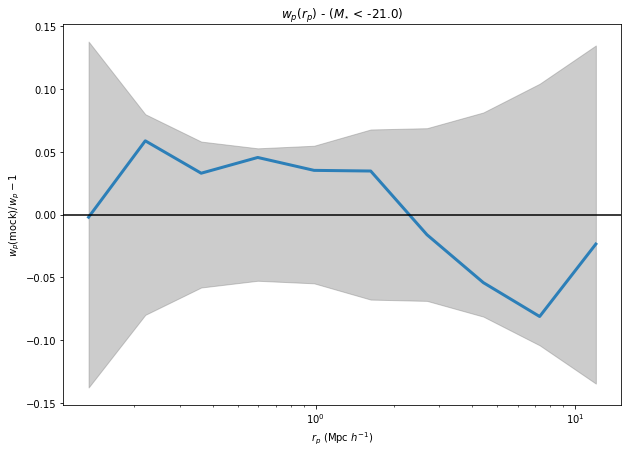

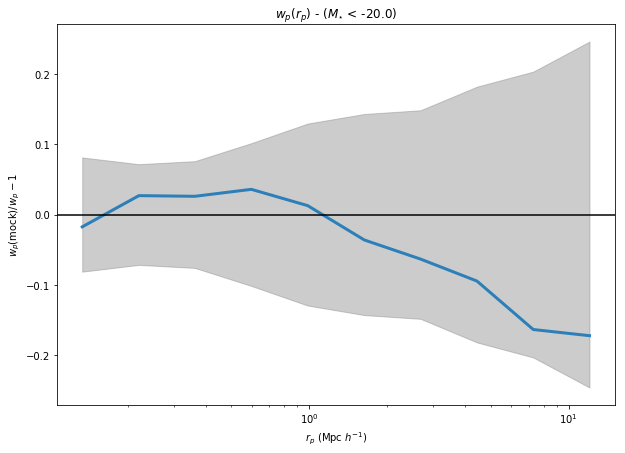

In [6]:
for wp_i,wp in enumerate(wp_binneds):
    plt.figure(figsize=(10,7))
    plt.plot(r_p_data,wp/wp_data_list[wp_i]-1,lw=3,c=custom_colors[2])
    plt.fill_between(r_p_data,-np.sqrt(np.diag(wp_cov_list[wp_i]))/wp_data_list[wp_i],
                     np.sqrt(np.diag(wp_cov_list[wp_i]))/wp_data_list[wp_i],
                     alpha=0.4,color='grey')
    plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cut_list[wp_i]))
    plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
    plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
    plt.xscale('log')
    plt.axhline(0,c='k')
    plt.show()

### Now let's scan over some values of scatter with our log likelihood function and make sure we like what we see

In [7]:
# Initialize the likelihood class and evaluate over our little grid
am_like = abundance_matching.AMLikelihood(wp_data_list,wp_cov_list,r_p_data,pimax=40.0,deconv_repeat=deconv_repeat,
                                         n_wp_samps=1)
n_samples = 15
scatters = np.linspace(0.0,0.4,n_samples)
log_likelihoods = np.zeros(n_samples)
for s_i, scatter in enumerate(scatters):
    log_likelihoods[s_i] = am_like.log_likelihood(np.array([scatter]))

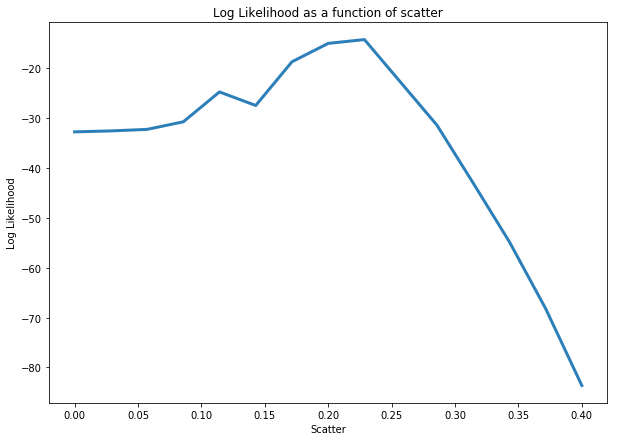

In [8]:
plt.figure(figsize=(10,7))
plt.plot(scatters,log_likelihoods,c=custom_colors[2],lw=3)
plt.title('Log Likelihood as a function of scatter')
plt.ylabel('Log Likelihood')
plt.xlabel('Scatter')
plt.show()

### Now we can set up an mcmc process, with pooling, to find our posterior on the scatter parameter

In [11]:
# Set up our sampler
n_walkers = 16
n_dim = 1
pool = Pool()
chain_path = '../chains/scat_chain.h5'

# Initialize our position if the chains don't already have a starting point
if not os.path.isfile(chain_path):
    pos_0 = np.random.uniform(size=(n_walkers,n_dim))*0.4
else:
    pos_0 = None
    
# Initialize our class again
am_like = abundance_matching.AMLikelihood(wp_data_list,wp_cov_list,r_p_data,pimax=40.0,deconv_repeat=deconv_repeat,
                                         n_wp_samps=1)

backend = emcee.backends.HDFBackend(chain_path)
sampler = emcee.EnsembleSampler(n_walkers,n_dim,am_like.log_likelihood,backend=backend,pool=pool)

In [12]:
# Run the sampler for a few steps
n_samps = 1000
sampler.run_mcmc(pos_0,n_samps,progress='notebook')

# In case we would like to run this cell again
pos_0 = None

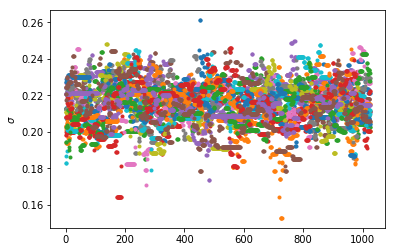

In [30]:
burnin = 60
chains = sampler.get_chain()[burnin:]
for chain in chains.T:
    plt.plot(chain.T,'.')
plt.ylabel(r'$\sigma$')
plt.show()

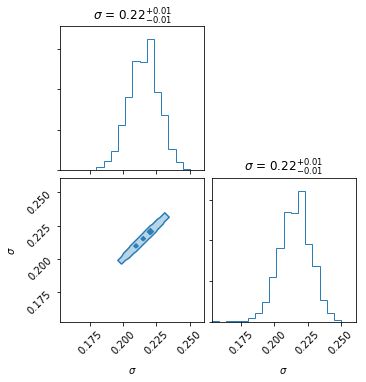

In [31]:
fake_chains = np.array([chains.flatten(),chains.flatten()])
corner.corner(fake_chains.T,labels=[r'$\sigma$',r'$\sigma$'],
                bins=20,show_titles=True, plot_datapoints=False,
                label_kwargs=dict(fontsize=10),
                levels=[0.68,0.95],color=custom_colors[2],fill_contours=True)
plt.show()

In [36]:
len(halos['upid'])

18241063